## Generative Adversarial Networks -- Mnist Dataset

In [1]:
import tensorflow as tf
import numpy as np 
import matplotlib 

In [2]:
tf.__version__, np.__version__, matplotlib.__version__

('2.17.0', '1.26.4', '3.9.2')

In [3]:
from tensorflow.keras.datasets import mnist
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import InputLayer, Dense, Flatten, Reshape
from tensorflow.keras.regularizers import L1L2
import matplotlib.pyplot as plt

In [4]:
(X_train, _),(_, _) = mnist.load_data()

In [5]:
X_train = X_train.astype('float32')/255

In [6]:
X_train.max(), X_train.min(), X_train.mean()

(1.0, 0.0, 0.13066062)

In [7]:
X_train.shape

(60000, 28, 28)

In [8]:
# creating a dataset in tensorflow format 

X_train = tf.data.Dataset.from_tensor_slices(X_train).shuffle(buffer_size=60000).batch(batch_size=256)

In [9]:
60000/256

234.375

In [10]:
# now we have a train dataset within a tensorflow class

type(X_train)

tensorflow.python.data.ops.batch_op._BatchDataset

In [11]:
# Generator 

# 100 -> 500 -> 500
generator = Sequential()
generator.add(Dense(units=500, input_dim=100, activation='relu', kernel_regularizer=L1L2(1e-5, 1e-5)))
generator.add(Dense(units=500, input_dim=100, activation='relu', kernel_regularizer=L1L2(1e-5, 1e-5)))
generator.add(Dense(units=784, activation='relu', kernel_regularizer=L1L2(1e-5, 1e-5)))
generator.add(Reshape((28, 28)))
generator.summary()


c:\Users\Matheus\Documents\GitHub\ai-experiments\ai-exp\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense (Dense)                   │ (None, 500)            │        50,500 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 500)            │       250,500 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 784)            │       392,784 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ reshape (Reshape)               │ (None, 28, 28)         │             0 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 693,784 (2.65 MB)

 Trainable params: 693,784 (2.65 MB)

 Non-trainable params: 0 (0.00 B)

In [12]:
# Discriminator 

# (28, 28)/784 -> 500 -> 500 -> 1
discriminator = Sequential()
discriminator.add(InputLayer(input_shape=(28,28)))
discriminator.add(Flatten())
discriminator.add(Dense(units=500, activation='relu', kernel_regularizer=L1L2(1e-5, 1e-5)))
discriminator.add(Dense(units=500, activation='relu', kernel_regularizer=L1L2(1e-5, 1e-5)))
discriminator.add(Dense(units=1, activation='sigmoid', kernel_regularizer=L1L2(1e-5, 1e-5)))

discriminator.summary()

c:\Users\Matheus\Documents\GitHub\ai-experiments\ai-exp\Lib\site-packages\keras\src\layers\core\input_layer.py:26: UserWarning: Argument `input_shape` is deprecated. Use `shape` instead.
  warnings.warn(


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ flatten (Flatten)               │ (None, 784)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 500)            │       392,500 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 500)            │       250,500 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 1)              │           501 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 643,501 (2.45 MB)

 Trainable params: 643,501 (2.45 MB)

 Non-trainable params: 0 (0.00 B)

In [13]:
cross_entropy = tf.keras.losses.BinaryCrossentropy()

In [14]:
# it is gonna measure how much discriminator predictions are close to 1 

def generator_loss(fake_output):
    return cross_entropy(tf.ones_like(fake_output), fake_output)

In [15]:
def discriminator_loss(real_output, fake_output):
    real_loss = cross_entropy(tf.ones_like(real_output), real_output)
    fake_loss = cross_entropy(tf.zeros_like(fake_output), fake_output)
    total_loss = real_loss + fake_loss
    return total_loss


In [16]:
generator_optimizer = tf.keras.optimizers.Adam(1e-4)
discriminator_optimizer = tf.keras.optimizers.Adam(1e-4)


In [17]:
epochs = 100
noise_dim = 100 # we have 100 neurons in the input layer

In [18]:
tf.random.normal([256, noise_dim])

<tf.Tensor: shape=(256, 100), dtype=float32, numpy=
array([[ 0.12456466, -0.15888439, -1.1383561 , ..., -0.355483  ,
        -0.26752898, -0.10589099],
       [ 1.254748  ,  0.7417683 , -0.04158139, ...,  0.5914004 ,
        -0.3624539 , -0.49196726],
       [-0.5552838 ,  0.24614148,  0.4549767 , ..., -1.361242  ,
         0.02795532, -0.00337626],
       ...,
       [-0.39239588, -0.2802829 ,  0.08904716, ..., -0.20048955,
         0.43038088,  0.30680877],
       [-0.76060903, -0.23544146, -1.4728067 , ...,  0.03683786,
        -0.66300356,  1.1886023 ],
       [ 0.6260052 ,  2.4962492 , -2.9508092 , ..., -0.696355  ,
         0.6202552 , -0.9640779 ]], dtype=float32)>

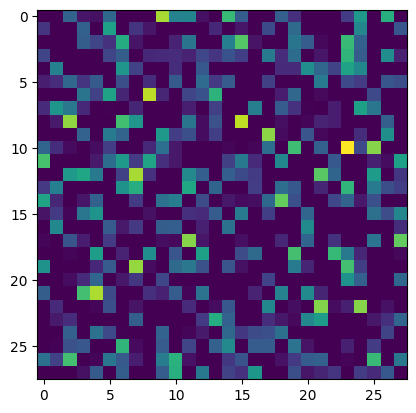

In [19]:
# random image (noise) that we are goint to pass throught the generator

plt.imshow(generator(tf.random.normal([256, noise_dim]))[2]);

In [20]:
def train_step(images):
    noise = tf.random.normal([256, noise_dim])

    with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:
        generated_images = generator(noise, training = True)

        real_output = discriminator(images, training = True)
        fake_output = discriminator(generated_images, training = True)

        gen_loss = generator_loss(fake_output)
        disc_loss = discriminator_loss(real_output, fake_output)

    gradients_of_generator = gen_tape.gradient(gen_loss, generator.trainable_variables)
    gradients_of_discriminator = disc_tape.gradient(disc_loss, discriminator.trainable_variables)

    generator_optimizer.apply_gradients(zip(gradients_of_generator, generator.trainable_variables))
    discriminator_optimizer.apply_gradients(zip(gradients_of_discriminator, discriminator.trainable_variables))

    return gen_loss, disc_loss
    

In [21]:
for epoch in range(epochs):
    for image_batch in X_train:
        gen_loss_batch, disc_loss_batch = train_step(image_batch)
    print(f'Epoch {epoch} | gen_loss: {gen_loss_batch} disc_loss {disc_loss_batch}')


Epoch 0 | gen_loss: 4.013865947723389 disc_loss 0.11504609882831573
Epoch 1 | gen_loss: 5.838214874267578 disc_loss 0.02614046260714531
Epoch 2 | gen_loss: 6.191848278045654 disc_loss 0.011800698935985565
Epoch 3 | gen_loss: 6.840458869934082 disc_loss 0.006849588360637426
Epoch 4 | gen_loss: 4.729139804840088 disc_loss 0.02697959542274475
Epoch 5 | gen_loss: 3.0430376529693604 disc_loss 0.06968468427658081
Epoch 6 | gen_loss: 5.090524673461914 disc_loss 0.009732275269925594
Epoch 7 | gen_loss: 5.986602783203125 disc_loss 0.01153264008462429
Epoch 8 | gen_loss: 6.984002113342285 disc_loss 0.0035203343722969294
Epoch 9 | gen_loss: 7.321023941040039 disc_loss 0.002435654168948531
Epoch 10 | gen_loss: 7.390728950500488 disc_loss 0.011291133239865303
Epoch 11 | gen_loss: 8.502321243286133 disc_loss 0.0031581204384565353
Epoch 12 | gen_loss: 8.6409912109375 disc_loss 0.002042694017291069
Epoch 13 | gen_loss: 8.14208984375 disc_loss 0.0012944787740707397
Epoch 14 | gen_loss: 8.24560356140136

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


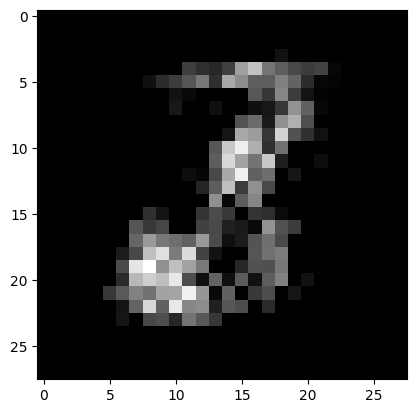

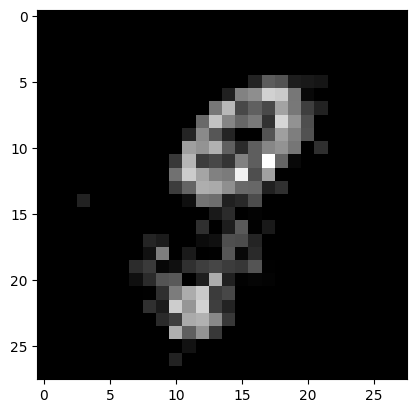

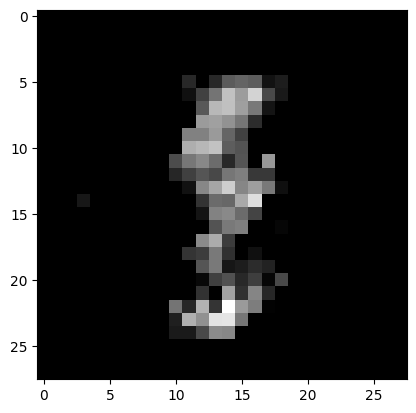

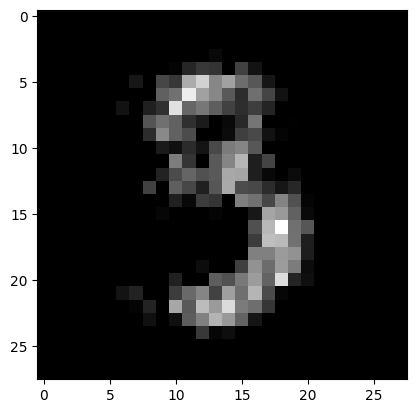

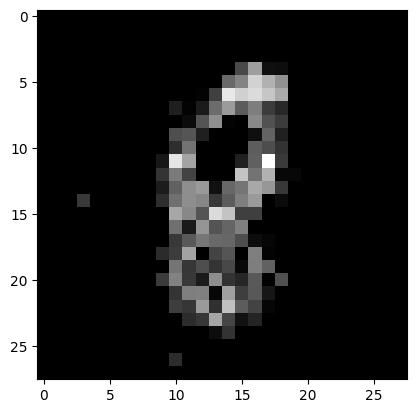

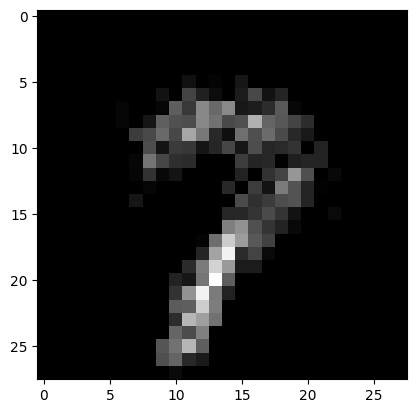

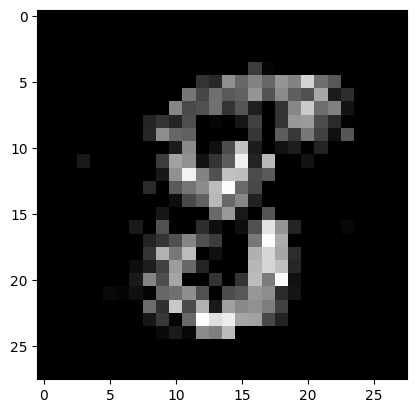

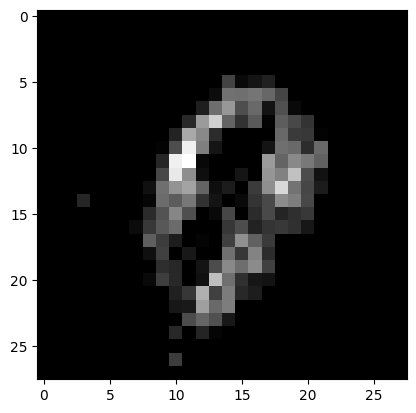

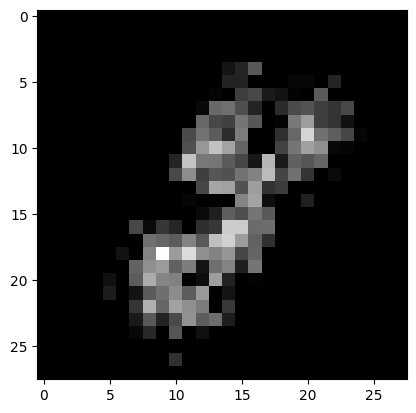

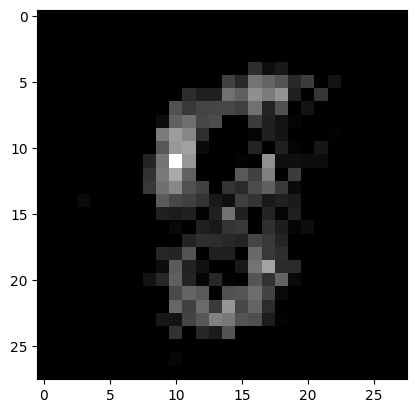

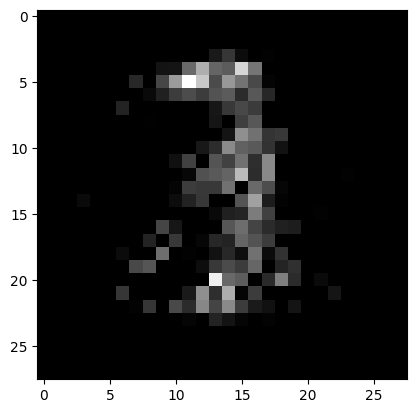

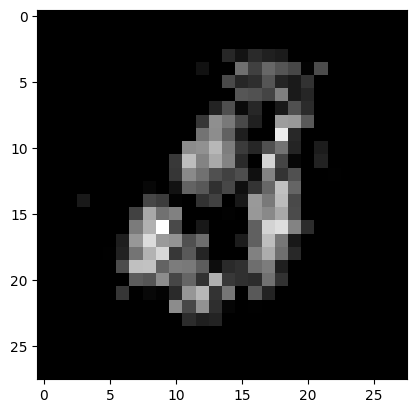

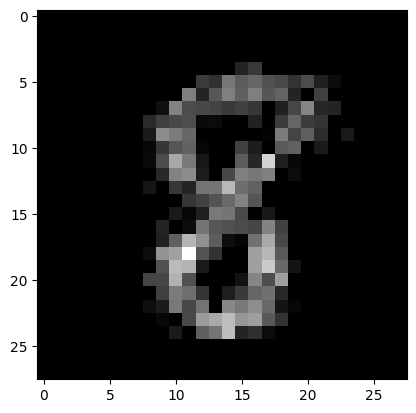

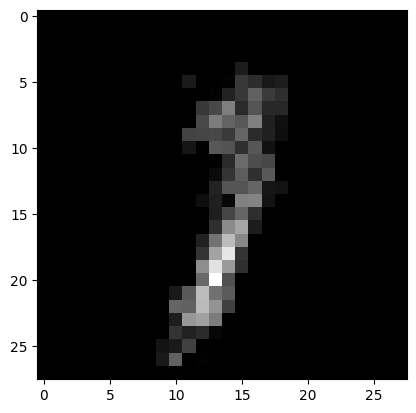

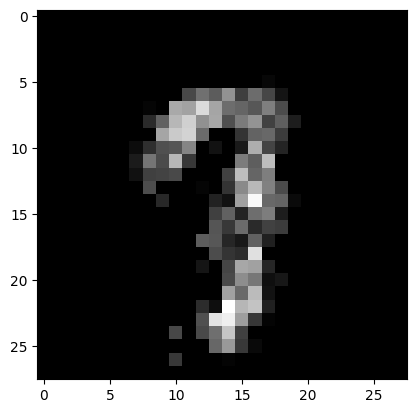

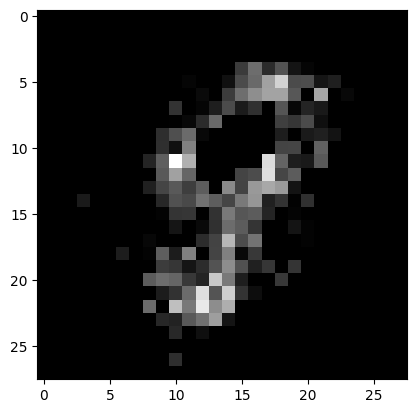

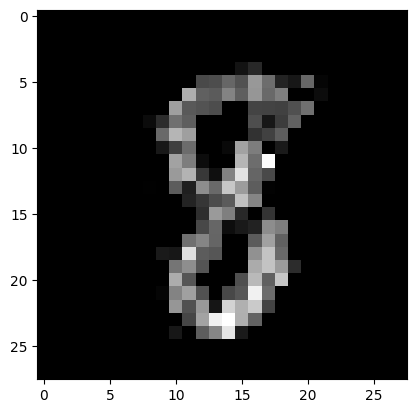

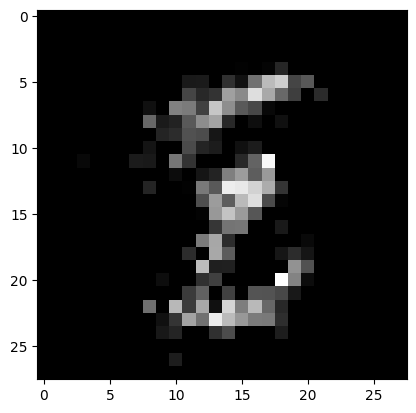

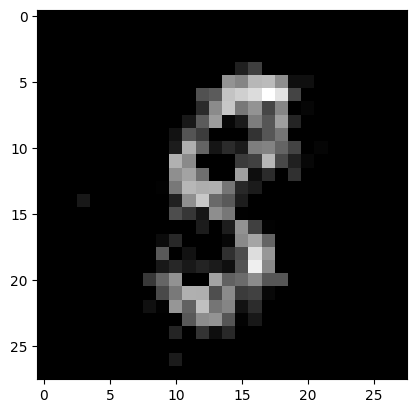

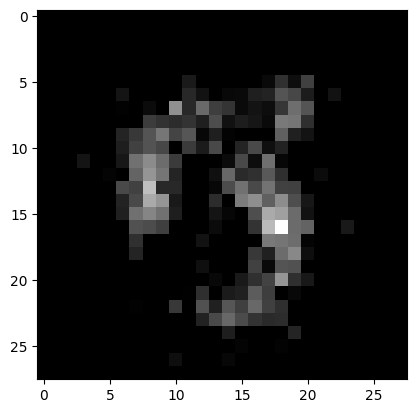

In [25]:
samples = np.random.normal(size=(20, 100))
predictions = generator.predict(samples)
for i in range(predictions.shape[0]):
    plt.imshow(predictions[i, :], cmap='gray')
    plt.show()